In [1]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


In [2]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR), f"{TRAIN_DIR} not found"
assert os.path.exists(TEST_DIR), f"{TEST_DIR} not found"
print(f"Dataset ready: {ROOT_DIR}")


Dataset ready: dataset/fruit360


In [3]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]


In [4]:
SIZE = 16
VARIETY = False

transform = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

train_full = Fruit360FolderDataset(TRAIN_DIR, transform=transform, variety=VARIETY)
test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform, variety=VARIETY)

train_size = int(0.7 * len(train_full))
val_size = len(train_full) - train_size

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

print(f"Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
print(f"Classes: {len(train_full.label_to_idx)}")


Training: 130344 images, 79 classes
Test: 43442 images, 79 classes
Train 91240, Val 39104, Test 43442
Classes: 79


In [5]:
BATCH_SIZE = 100

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"{len(train_loader)} train batches, {len(val_loader)} val batches, {len(test_loader)} test batches")


913 train batches, 392 val batches, 435 test batches


In [6]:
def extract_numpy(loader):
    X_list, y_list = [], []
    for imgs, labels in loader:
        X_list.append(imgs.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = extract_numpy(train_loader)
X_val, y_val = extract_numpy(val_loader)
X_test, y_test = extract_numpy(test_loader)

print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")


X_train (91240, 3, 16, 16), y_train (91240,)
X_val (39104, 3, 16, 16), y_val (39104,)
X_test (43442, 3, 16, 16), y_test (43442,)


In [7]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened shape: {X_train_flat.shape}")

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_flat)
X_val_sc = scaler.transform(X_val_flat)
X_test_sc = scaler.transform(X_test_flat)

print(f"Features per sample: {X_train_flat.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print("Standardization done")


Flattened shape: (91240, 768)
Features per sample: 768
Number of classes: 79
Standardization done


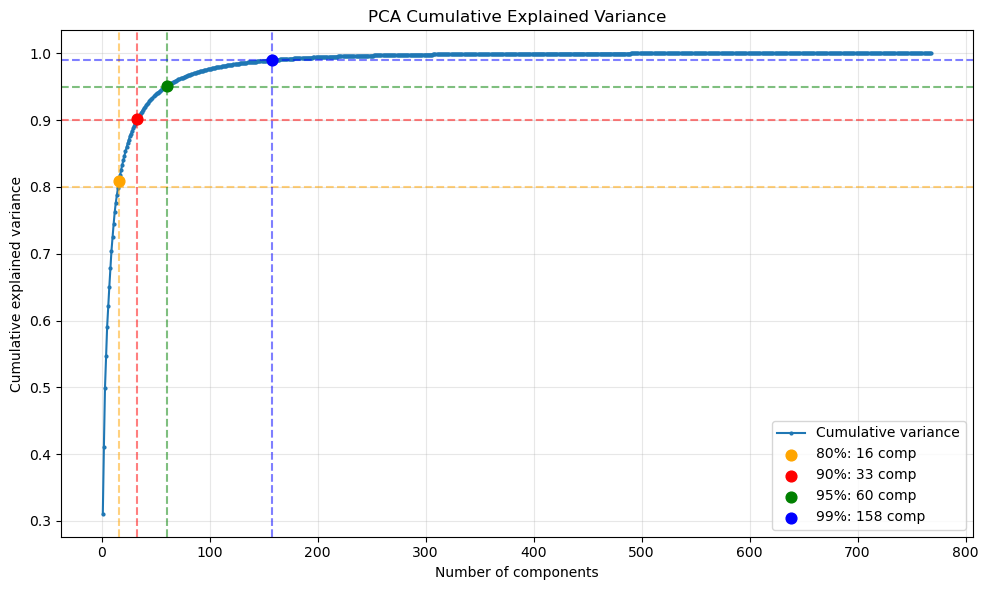

Components needed for each variance target:
  80% variance: 16 components
  90% variance: 33 components
  95% variance: 60 components
  99% variance: 158 components


In [8]:
pca_full = PCA(n_components=min(X_train_sc.shape), random_state=RANDOM_STATE)
pca_full.fit(X_train_sc)

explained = pca_full.explained_variance_ratio_
cumsum = np.cumsum(explained)

targets = [0.80, 0.90, 0.95, 0.99]
components_for_target = {}

for t in targets:
    k = np.argmax(cumsum >= t) + 1
    components_for_target[t] = k

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', markersize=2, label='Cumulative variance')

colors = ['orange', 'red', 'green', 'blue']
for (t, k), col in zip(components_for_target.items(), colors):
    plt.axhline(t, color=col, linestyle='--', alpha=0.5)
    plt.axvline(k, color=col, linestyle='--', alpha=0.5)
    plt.scatter(k, cumsum[k-1], color=col, s=60, zorder=5, 
                label=f'{int(t*100)}%: {k} comp')

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Components needed for each variance target:")
for t, k in components_for_target.items():
    print(f"  {int(t*100)}% variance: {k} components")


In [9]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

n_components_candidates = [
    components_for_target[0.90],
    components_for_target[0.95],
    components_for_target[0.99],
]

k_values = [1, 3, 5, 7]
rf_configs = [
    {"n_estimators": 100, "max_depth": None},
    {"n_estimators": 100, "max_depth": 20},
    {"n_estimators": 200, "max_depth": None},
    {"n_estimators": 200, "max_depth": 20},
]

knn_results = []
rf_results = []

for n_comp in n_components_candidates:

    pca_temp = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_train_pca = pca_temp.fit_transform(X_train_sc)
    X_val_pca = pca_temp.transform(X_val_sc)
    X_test_pca = pca_temp.transform(X_test_sc)
    
    print(f"\n=== Testing with {n_comp} PCA components ===")
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train_pca, y_train)
        
        val_acc = accuracy_score(y_val, knn.predict(X_val_pca))
        test_acc = accuracy_score(y_test, knn.predict(X_test_pca))
        
        knn_results.append({
            'n_components': n_comp,
            'k': k,
            'val_acc': val_acc,
            'test_acc': test_acc,
        })
        print(f"KNN (k={k}): Val acc={val_acc:.4f}, Test acc={test_acc:.4f}")
    
    for cfg in rf_configs:
        rf = RandomForestClassifier(
            n_estimators=cfg["n_estimators"],
            max_depth=cfg["max_depth"],
            random_state=RANDOM_STATE,
            n_jobs=-1,
        )
        rf.fit(X_train_pca, y_train)
        
        val_acc = accuracy_score(y_val, rf.predict(X_val_pca))
        test_acc = accuracy_score(y_test, rf.predict(X_test_pca))
        
        rf_results.append({
            'n_components': n_comp,
            'n_estimators': cfg["n_estimators"],
            'max_depth': cfg["max_depth"],
            'val_acc': val_acc,
            'test_acc': test_acc,
        })
        print(f"RF (n_est={cfg['n_estimators']}, depth={cfg['max_depth']}) "
              f"-> Val acc={val_acc:.4f}, Test acc={test_acc:.4f}")

knn_results_df = pd.DataFrame(knn_results).sort_values('test_acc', ascending=False)
rf_results_df = pd.DataFrame(rf_results).sort_values('test_acc', ascending=False)

print("\n" + "="*60)
print("KNN RESULTS (sorted by test_acc):")
print(knn_results_df.head(10))

best_knn = knn_results_df.iloc[0]
print("\nBEST KNN CONFIGURATION:")
print(f"n_components: {int(best_knn['n_components'])}")
print(f"k: {int(best_knn['k'])}")
print(f"Val accuracy: {best_knn['val_acc']:.4f}")
print(f"Test accuracy: {best_knn['test_acc']:.4f}")

print("\n" + "="*60)
print("RANDOM FOREST RESULTS (sorted by test_acc):")
print(rf_results_df.head(10))

best_rf = rf_results_df.iloc[0]
print("\nBEST RANDOM FOREST CONFIGURATION:")
print(f"n_components: {int(best_rf['n_components'])}")
print(f"n_estimators: {int(best_rf['n_estimators'])}")
print(f"max_depth: {best_rf['max_depth']}")
print(f"Val accuracy: {best_rf['val_acc']:.4f}")
print(f"Test accuracy: {best_rf['test_acc']:.4f}")


=== Testing with 33 PCA components ===
KNN (k=1): Val acc=0.9992, Test acc=0.9567
KNN (k=3): Val acc=0.9973, Test acc=0.9474
KNN (k=5): Val acc=0.9949, Test acc=0.9391
KNN (k=7): Val acc=0.9924, Test acc=0.9320
RF (n_est=100, depth=None) -> Val acc=0.9971, Test acc=0.9330
RF (n_est=100, depth=20) -> Val acc=0.9942, Test acc=0.9227
RF (n_est=200, depth=None) -> Val acc=0.9975, Test acc=0.9361
RF (n_est=200, depth=20) -> Val acc=0.9947, Test acc=0.9255

=== Testing with 60 PCA components ===
KNN (k=1): Val acc=0.9993, Test acc=0.9614
KNN (k=3): Val acc=0.9979, Test acc=0.9528
KNN (k=5): Val acc=0.9958, Test acc=0.9445
KNN (k=7): Val acc=0.9936, Test acc=0.9381
RF (n_est=100, depth=None) -> Val acc=0.9973, Test acc=0.9296
RF (n_est=100, depth=20) -> Val acc=0.9945, Test acc=0.9219
RF (n_est=200, depth=None) -> Val acc=0.9978, Test acc=0.9325
RF (n_est=200, depth=20) -> Val acc=0.9950, Test acc=0.9236

=== Testing with 158 PCA components ===
KNN (k=1): Val acc=0.9995, Test acc=0.9619
KNN 